# Convolutional Neural Network

**Notes about this specific notebook**

Uses rgb, 128x128 images with ReLU activation and Adam optimizer. No class or sample specific weights are used

# Changeable Parameters

_____________________________________________________________________

In [37]:
# Image size (height x width)
ih = 128
iw = 128

# Grayscale or RGB
ch = 'grayscale'

# Batch size
batch_size = 40000

# Number of epochs
epoch_t = 50

# Where computation is performed: Kaggle (0) or Local (1)
cenv = 1

# Division of the training vs. test set 
test_size = 0.3

# number of folds
n_folds = 10

_____________________________________________________________________

In [38]:
# To check whether the right environment has been selected
if cenv == 0:
    print("Computation environment: Kaggle")
if cenv == 1:
    print("Computation environment: Local")

Computation environment: Local


Import the necessary libraries

In [39]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np
from sklearn.utils import class_weight
from sklearn import metrics
import sys
import os
from math import log
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Check whether a, and which GPU is available for the computation

In [40]:
is_cuda_gpu_available = tf.config.list_physical_devices('GPU')
print(is_cuda_gpu_available)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [41]:
# Image size
im_si = (ih, iw)

# Convert the color channel to the corresponding number of layers
if(ch == 'rgb'):
    chnum = 3
elif(ch == 'grayscale'):
    chnum = 1

Create new directory for saving output files if computation is done locally

In [42]:
if cenv == 1:
    file_exists = []
    vnum = 1
    dir = "C:/Users/Max/OneDrive - Erasmus University Rotterdam/Documents/GitHub/malimg_dataset"
    for files in os.listdir(dir):
        if "crossv-cnn" in files:
            try:
                vnum = max(vnum, int(files[-3:]))
            except: 
                continue
            new_vnum = vnum + 1
            file_exists.append(True)
        else: 
            file_exists.append(False)
    # If this is the first notebook you want to save, a new folder will be created with version #001
    if sum(file_exists) == 0:
        new_vnum = 1
        print("No matches found")

    else: 
        print(f"{sum(file_exists)} matches(es) found")
        print("--------------")

    # Print new folder name
    print(f"New folder name: crossv-cnn128-local-v{new_vnum:03}")
    print("--------------")
    
    # Create new folder with the name of the notebook and the version number
    new_dir = f"C:/Users/Max/OneDrive - Erasmus University Rotterdam/Documents/GitHub/malimg_dataset/crossv-cnn128-local-v{new_vnum:03}"
    os.makedirs(new_dir)

7 matches(es) found
--------------
New folder name: crossv-cnn128-local-v008
--------------


**Data**


In [43]:
if cenv == 0:
    path_root = "/kaggle/input/thesis-data"

if cenv == 1:
    path_root = "C:/Users/Max/OneDrive - Erasmus University Rotterdam/Documents/image_data/malimg_paper_dataset_imgs/"

Load the data. No data augmentation takes place

In [44]:
batches = ImageDataGenerator().flow_from_directory(
    directory     = path_root, 
    color_mode    = ch, 
    target_size   = (ih,iw), 
    batch_size    = batch_size,
    interpolation = 'bicubic'
)
imgs, labels = next(batches)

Found 9339 images belonging to 25 classes.


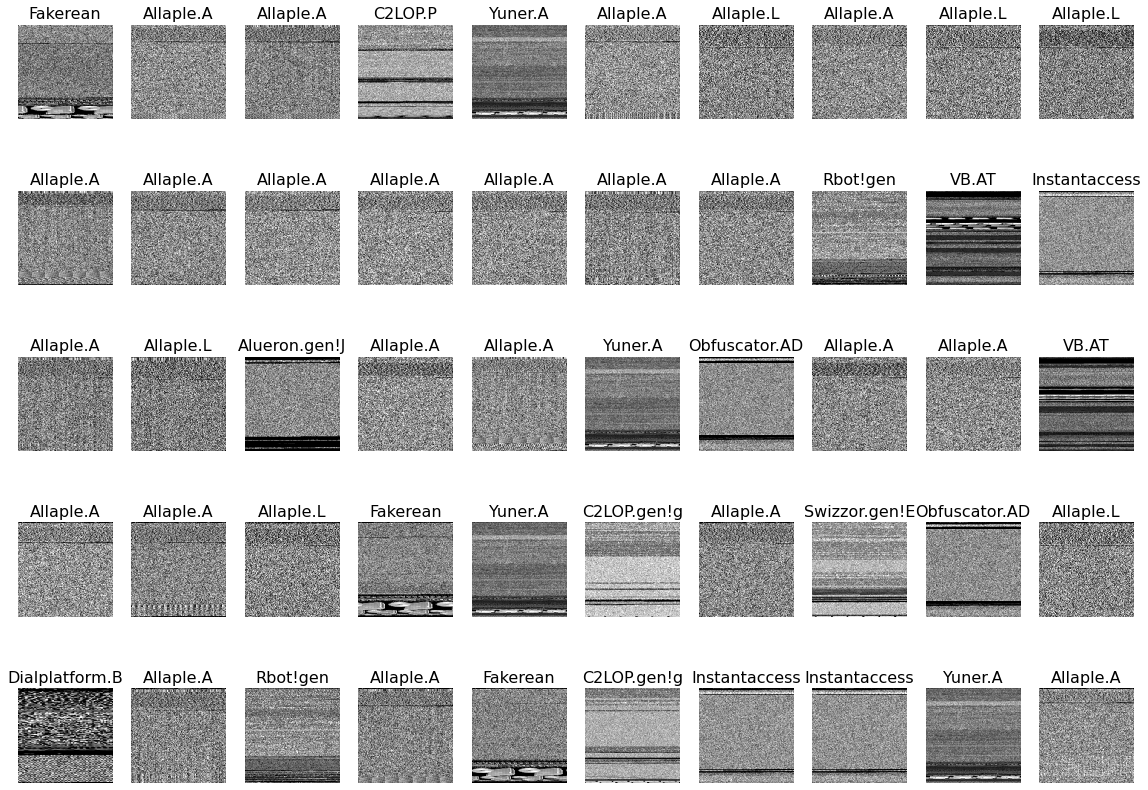

In [45]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != chnum):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], cmap = 'gray',interpolation=None if interp else 'none')
        
plots(imgs, titles = labels)

In [46]:
# A dictionary of all the different classes
classes = batches.class_indices.keys()
x = np.arange(len(list(classes)))

Plot data distribution among all classes

Standardize images

In [47]:
imgs = imgs / 255.0

Plot data distribution among train, val. and test set

# Convolutional Neural Network
We will now build our **CNN** model using Keras. This model will have the following layers :

* **Convolutional Layer** : 30 filters, (3 * 3) kernel size
* **Max Pooling Layer** : (2 * 2) pool size
* **Convolutional Layer** : 15 filters, (3 * 3) kernel size
* **Max Pooling Layer** : (2 * 2) pool size
* **DropOut Layer** : Dropping 25% of neurons.
* **Flatten Layer**
* **Dense/Fully Connected Layer** : 128 Neurons, ReLU activation function
* **DropOut Layer** : Dropping 50% of neurons.
* **Dense/Fully Connected Layer** : 50 Neurons, Softmax activation function
* **Dense/Fully Connected Layer** : num_class Neurons, Softmax activation function

**Input shape** : 64 * 64 * 1

In [48]:
import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import KFold

In [49]:
from sklearn.metrics import f1_score, matthews_corrcoef, accuracy_score
from prettytable import PrettyTable, MSWORD_FRIENDLY

We want **11** classes

In [50]:
num_classes = len(list(batches.class_indices))
print("The number of classes in our dataset: ", num_classes)

The number of classes in our dataset:  25


Building the model

Reduce learning rate after 5 epochs of no improvement on the validition accuracy. Also save save checkpoints for the best performing model based on validation loss

In [51]:
def malware_model():
        Malware_model = Sequential()
        Malware_model.add(Conv2D(30, kernel_size=(3, 3),
                         activation='relu',
                         input_shape=(ih,iw,chnum)))

        Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
        Malware_model.add(Conv2D(15, (3, 3), activation='relu'))
        Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
        Malware_model.add(Dropout(0.25))
        Malware_model.add(Flatten())
        Malware_model.add(Dense(128, activation='relu'))
        Malware_model.add(Dropout(0.5))
        Malware_model.add(Dense(50, activation='relu'))
        Malware_model.add(Dense(num_classes, activation='softmax'))
        Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
        return Malware_model

In [52]:
def confusion_matrix_bin_model(confusion_matrix, class_names_bin, figsize = (5,2), fontsize=7):

        df_cm = pd.DataFrame(
            confusion_matrix, index=class_names_bin, columns=class_names_bin, 
        )
        fig = plt.figure(figsize=figsize)
        try:
            heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
        except ValueError:
            raise ValueError("Confusion matrix values must be integers.")
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

class_names_bin= ("ransomware", "benign")

In [53]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-4)
if cenv == 0:
    checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
if cenv == 1:
    checkpoint = ModelCheckpoint(f'{new_dir}/model.h5', verbose=1, save_best_only=True)


In [54]:
# Performance metrics
multi_acc_per_fold = []
loss_per_fold = []
multi_f1_per_fold = []

bin_acc_per_fold = []
bin_tpr_per_fold = []
bin_f1_per_fold = []
bin_mcc_per_fold = []

tp = []
fp = []
fn = []
tn = []

y_pred = []
y_true = []

rw_count = []
bn_count = []

# History
history = []

# Data distribution
train_distr = []
test_distr= []

In [55]:
kfold = KFold(n_splits=n_folds, shuffle=True)

In [56]:
fold_no = 1

for train, test in kfold.split(imgs,labels):
    
    # Compile the CNN
    Malware_model = malware_model()
    
    # Run the CNN
    history.append(
        Malware_model.fit(
        imgs[train], 
        labels[train], 
        validation_data=(imgs[test], labels[test]), 
        epochs=epoch_t,
        callbacks = [anne, checkpoint]) # The actual computation of the CNN
    )
    
    # Generate generalization metrics
    scores = Malware_model.evaluate(imgs[test], labels[test], verbose=0)
    print(f'Score for fold {fold_no}: {Malware_model.metrics_names[0]} of {scores[0]}; {Malware_model.metrics_names[1]} of {scores[1]*100}%')
    multi_acc_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1
    
    # Create two 1D-arrays: one with the prediction per image of the model and one with the true labels
    y_pred = np.append(y_pred, np.argmax(Malware_model.predict(imgs[test]), axis=-1))
    y_true = np.append(y_true, np.argmax(labels[test], axis=1))
    
    y_pred2 = np.argmax(Malware_model.predict(imgs[test]), axis=-1)
    y_true2 = np.argmax(labels[test], axis=1)
    
    multi_f1_per_fold.append(f1_score(y_true2, y_pred2, average='macro'))
    
    train_distr.append((sum(labels[train])/labels[train].shape[0])*100)
    test_distr.append((sum(labels[test])/labels[test].shape[0])*100)
    

Epoch 1/50
263/263 [==============================] - 4s 14ms/step - loss: 1.4166 - accuracy: 0.5842 - val_loss: 0.5688 - val_accuracy: 0.8266

Epoch 00001: val_loss improved from inf to 0.56881, saving model to C:/Users/Max/OneDrive - Erasmus University Rotterdam/Documents/GitHub/malimg_dataset/crossv-cnn128-local-v008\model.h5
Epoch 2/50
263/263 [==============================] - 3s 13ms/step - loss: 0.5000 - accuracy: 0.8500 - val_loss: 0.3326 - val_accuracy: 0.8758

Epoch 00002: val_loss improved from 0.56881 to 0.33263, saving model to C:/Users/Max/OneDrive - Erasmus University Rotterdam/Documents/GitHub/malimg_dataset/crossv-cnn128-local-v008\model.h5
Epoch 3/50
263/263 [==============================] - 4s 13ms/step - loss: 0.3315 - accuracy: 0.8986 - val_loss: 0.1970 - val_accuracy: 0.9293

Epoch 00003: val_loss improved from 0.33263 to 0.19702, saving model to C:/Users/Max/OneDrive - Erasmus University Rotterdam/Documents/GitHub/malimg_dataset/crossv-cnn128-local-v008\model.h5

263/263 [==============================] - 3s 12ms/step - loss: 0.0733 - accuracy: 0.9743 - val_loss: 0.0938 - val_accuracy: 0.9700

Epoch 00033: val_loss did not improve from 0.08850
Epoch 34/50
263/263 [==============================] - 3s 13ms/step - loss: 0.0773 - accuracy: 0.9725 - val_loss: 0.0943 - val_accuracy: 0.9668

Epoch 00034: val_loss did not improve from 0.08850
Epoch 35/50
263/263 [==============================] - 3s 12ms/step - loss: 0.0759 - accuracy: 0.9730 - val_loss: 0.0915 - val_accuracy: 0.9668

Epoch 00035: val_loss did not improve from 0.08850
Epoch 36/50
263/263 [==============================] - 3s 13ms/step - loss: 0.0777 - accuracy: 0.9725 - val_loss: 0.0878 - val_accuracy: 0.9700

Epoch 00036: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00036: val_loss improved from 0.08850 to 0.08784, saving model to C:/Users/Max/OneDrive - Erasmus University Rotterdam/Documents/GitHub/malimg_dataset/crossv-cnn128-local-v008\model.h5
Epoch 3

263/263 [==============================] - 3s 13ms/step - loss: 0.0792 - accuracy: 0.9714 - val_loss: 0.1105 - val_accuracy: 0.9732

Epoch 00022: val_loss did not improve from 0.08610
Epoch 23/50
263/263 [==============================] - 3s 13ms/step - loss: 0.0764 - accuracy: 0.9750 - val_loss: 0.1085 - val_accuracy: 0.9743

Epoch 00023: val_loss did not improve from 0.08610
Epoch 24/50
263/263 [==============================] - 3s 12ms/step - loss: 0.0796 - accuracy: 0.9724 - val_loss: 0.0978 - val_accuracy: 0.9732

Epoch 00024: val_loss did not improve from 0.08610
Epoch 25/50
263/263 [==============================] - 3s 12ms/step - loss: 0.0736 - accuracy: 0.9744 - val_loss: 0.1119 - val_accuracy: 0.9711

Epoch 00025: val_loss did not improve from 0.08610
Epoch 26/50
263/263 [==============================] - 3s 12ms/step - loss: 0.0766 - accuracy: 0.9737 - val_loss: 0.1048 - val_accuracy: 0.9754

Epoch 00026: val_loss did not improve from 0.08610
Epoch 27/50
263/263 [===========


Epoch 00011: val_loss did not improve from 0.08160
Epoch 12/50
263/263 [==============================] - 3s 13ms/step - loss: 0.1188 - accuracy: 0.9582 - val_loss: 0.0988 - val_accuracy: 0.9668

Epoch 00012: val_loss did not improve from 0.08160
Epoch 13/50
263/263 [==============================] - 3s 13ms/step - loss: 0.1237 - accuracy: 0.9572 - val_loss: 0.0925 - val_accuracy: 0.9754

Epoch 00013: val_loss did not improve from 0.08160
Epoch 14/50
263/263 [==============================] - 3s 13ms/step - loss: 0.1122 - accuracy: 0.9620 - val_loss: 0.0795 - val_accuracy: 0.9764

Epoch 00014: val_loss improved from 0.08160 to 0.07946, saving model to C:/Users/Max/OneDrive - Erasmus University Rotterdam/Documents/GitHub/malimg_dataset/crossv-cnn128-local-v008\model.h5
Epoch 15/50
263/263 [==============================] - 3s 12ms/step - loss: 0.1069 - accuracy: 0.9617 - val_loss: 0.0752 - val_accuracy: 0.9732

Epoch 00015: val_loss improved from 0.07946 to 0.07516, saving model to C:/


Epoch 00048: ReduceLROnPlateau reducing learning rate to 0.0001.

Epoch 00048: val_loss did not improve from 0.05303
Epoch 49/50
263/263 [==============================] - 3s 13ms/step - loss: 0.0520 - accuracy: 0.9825 - val_loss: 0.0618 - val_accuracy: 0.9839

Epoch 00049: val_loss did not improve from 0.05303
Epoch 50/50
263/263 [==============================] - 3s 12ms/step - loss: 0.0519 - accuracy: 0.9820 - val_loss: 0.0629 - val_accuracy: 0.9829

Epoch 00050: val_loss did not improve from 0.05303
Score for fold 3: loss of 0.06289993226528168; accuracy of 98.28693866729736%
Epoch 1/50
263/263 [==============================] - 4s 13ms/step - loss: 1.2191 - accuracy: 0.6594 - val_loss: 0.2287 - val_accuracy: 0.9154

Epoch 00001: val_loss did not improve from 0.05303
Epoch 2/50
263/263 [==============================] - 3s 13ms/step - loss: 0.3397 - accuracy: 0.9023 - val_loss: 0.1284 - val_accuracy: 0.9647

Epoch 00002: val_loss did not improve from 0.05303
Epoch 3/50
263/263 [==


Epoch 00038: val_loss did not improve from 0.05303
Epoch 39/50
263/263 [==============================] - 3s 12ms/step - loss: 0.0599 - accuracy: 0.9791 - val_loss: 0.0722 - val_accuracy: 0.9807

Epoch 00039: val_loss did not improve from 0.05303
Epoch 40/50
263/263 [==============================] - 3s 12ms/step - loss: 0.0573 - accuracy: 0.9806 - val_loss: 0.0715 - val_accuracy: 0.9764

Epoch 00040: ReduceLROnPlateau reducing learning rate to 0.0001.

Epoch 00040: val_loss did not improve from 0.05303
Epoch 41/50
263/263 [==============================] - 3s 12ms/step - loss: 0.0572 - accuracy: 0.9793 - val_loss: 0.0761 - val_accuracy: 0.9786

Epoch 00041: val_loss did not improve from 0.05303
Epoch 42/50
263/263 [==============================] - 3s 12ms/step - loss: 0.0554 - accuracy: 0.9804 - val_loss: 0.0734 - val_accuracy: 0.9775

Epoch 00042: val_loss did not improve from 0.05303
Epoch 43/50
263/263 [==============================] - 3s 12ms/step - loss: 0.0549 - accuracy: 0.9

263/263 [==============================] - 3s 13ms/step - loss: 0.0821 - accuracy: 0.9728 - val_loss: 0.0732 - val_accuracy: 0.9711

Epoch 00029: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00029: val_loss did not improve from 0.05303
Epoch 30/50
263/263 [==============================] - 3s 13ms/step - loss: 0.0735 - accuracy: 0.9738 - val_loss: 0.0671 - val_accuracy: 0.9764

Epoch 00030: val_loss did not improve from 0.05303
Epoch 31/50
263/263 [==============================] - 3s 12ms/step - loss: 0.0768 - accuracy: 0.9723 - val_loss: 0.0635 - val_accuracy: 0.9786

Epoch 00031: val_loss did not improve from 0.05303
Epoch 32/50
263/263 [==============================] - 3s 12ms/step - loss: 0.0751 - accuracy: 0.9745 - val_loss: 0.0642 - val_accuracy: 0.9797

Epoch 00032: val_loss did not improve from 0.05303
Epoch 33/50
263/263 [==============================] - 3s 12ms/step - loss: 0.0723 - accuracy: 0.9748 - val_loss: 0.0626 - val_accuracy: 0.9786

Ep

263/263 [==============================] - 3s 12ms/step - loss: 0.1002 - accuracy: 0.9657 - val_loss: 0.1062 - val_accuracy: 0.9732

Epoch 00020: val_loss did not improve from 0.05303
Epoch 21/50
263/263 [==============================] - 3s 12ms/step - loss: 0.0936 - accuracy: 0.9679 - val_loss: 0.1114 - val_accuracy: 0.9722

Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00021: val_loss did not improve from 0.05303
Epoch 22/50
263/263 [==============================] - 3s 12ms/step - loss: 0.0877 - accuracy: 0.9695 - val_loss: 0.1209 - val_accuracy: 0.9700

Epoch 00022: val_loss did not improve from 0.05303
Epoch 23/50
263/263 [==============================] - 3s 12ms/step - loss: 0.0811 - accuracy: 0.9707 - val_loss: 0.1141 - val_accuracy: 0.9722

Epoch 00023: val_loss did not improve from 0.05303
Epoch 24/50
263/263 [==============================] - 3s 13ms/step - loss: 0.0757 - accuracy: 0.9741 - val_loss: 0.1131 - val_accuracy: 0.9754

Ep

263/263 [==============================] - 3s 12ms/step - loss: 0.1745 - accuracy: 0.9461 - val_loss: 0.1415 - val_accuracy: 0.9647

Epoch 00010: val_loss did not improve from 0.05303
Epoch 11/50
263/263 [==============================] - 3s 12ms/step - loss: 0.1277 - accuracy: 0.9560 - val_loss: 0.1277 - val_accuracy: 0.9668

Epoch 00011: val_loss did not improve from 0.05303
Epoch 12/50
263/263 [==============================] - 3s 12ms/step - loss: 0.1169 - accuracy: 0.9623 - val_loss: 0.1287 - val_accuracy: 0.9625

Epoch 00012: val_loss did not improve from 0.05303
Epoch 13/50
263/263 [==============================] - 3s 12ms/step - loss: 0.1103 - accuracy: 0.9636 - val_loss: 0.1165 - val_accuracy: 0.9657

Epoch 00013: val_loss did not improve from 0.05303
Epoch 14/50
263/263 [==============================] - 3s 12ms/step - loss: 0.1064 - accuracy: 0.9655 - val_loss: 0.1084 - val_accuracy: 0.9722

Epoch 00014: val_loss did not improve from 0.05303
Epoch 15/50
263/263 [===========

263/263 [==============================] - 3s 12ms/step - loss: 0.0587 - accuracy: 0.9785 - val_loss: 0.1193 - val_accuracy: 0.9722

Epoch 00050: val_loss did not improve from 0.05303
Score for fold 7: loss of 0.11925011873245239; accuracy of 97.21627235412598%
Epoch 1/50
263/263 [==============================] - 4s 13ms/step - loss: 1.3473 - accuracy: 0.6099 - val_loss: 0.2856 - val_accuracy: 0.9261

Epoch 00001: val_loss did not improve from 0.05303
Epoch 2/50
263/263 [==============================] - 3s 12ms/step - loss: 0.4035 - accuracy: 0.8764 - val_loss: 0.1572 - val_accuracy: 0.9518

Epoch 00002: val_loss did not improve from 0.05303
Epoch 3/50
263/263 [==============================] - 3s 13ms/step - loss: 0.2963 - accuracy: 0.9073 - val_loss: 0.1257 - val_accuracy: 0.9572

Epoch 00003: val_loss did not improve from 0.05303
Epoch 4/50
263/263 [==============================] - 3s 13ms/step - loss: 0.2320 - accuracy: 0.9268 - val_loss: 0.1237 - val_accuracy: 0.9572

Epoch 000

263/263 [==============================] - 3s 12ms/step - loss: 0.0609 - accuracy: 0.9786 - val_loss: 0.0657 - val_accuracy: 0.9775

Epoch 00040: val_loss did not improve from 0.05303
Epoch 41/50
263/263 [==============================] - 3s 12ms/step - loss: 0.0667 - accuracy: 0.9763 - val_loss: 0.0684 - val_accuracy: 0.9775

Epoch 00041: val_loss did not improve from 0.05303
Epoch 42/50
263/263 [==============================] - 3s 12ms/step - loss: 0.0629 - accuracy: 0.9781 - val_loss: 0.0659 - val_accuracy: 0.9775

Epoch 00042: val_loss did not improve from 0.05303
Epoch 43/50
263/263 [==============================] - 3s 13ms/step - loss: 0.0630 - accuracy: 0.9786 - val_loss: 0.0691 - val_accuracy: 0.9754

Epoch 00043: val_loss did not improve from 0.05303
Epoch 44/50
263/263 [==============================] - 3s 12ms/step - loss: 0.0639 - accuracy: 0.9797 - val_loss: 0.0719 - val_accuracy: 0.9754

Epoch 00044: val_loss did not improve from 0.05303
Epoch 45/50
263/263 [===========


Epoch 00030: val_loss did not improve from 0.05303
Epoch 31/50
263/263 [==============================] - 3s 13ms/step - loss: 0.0921 - accuracy: 0.9664 - val_loss: 0.0979 - val_accuracy: 0.9647

Epoch 00031: val_loss did not improve from 0.05303
Epoch 32/50
263/263 [==============================] - 3s 13ms/step - loss: 0.0901 - accuracy: 0.9685 - val_loss: 0.1007 - val_accuracy: 0.9647

Epoch 00032: val_loss did not improve from 0.05303
Epoch 33/50
263/263 [==============================] - 3s 13ms/step - loss: 0.0859 - accuracy: 0.9692 - val_loss: 0.0909 - val_accuracy: 0.9647

Epoch 00033: val_loss did not improve from 0.05303
Epoch 34/50
263/263 [==============================] - 4s 14ms/step - loss: 0.0893 - accuracy: 0.9678 - val_loss: 0.0920 - val_accuracy: 0.9668

Epoch 00034: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00034: val_loss did not improve from 0.05303
Epoch 35/50
263/263 [==============================] - 3s 13ms/step - loss: 0.0844 

263/263 [==============================] - 3s 13ms/step - loss: 0.1030 - accuracy: 0.9651 - val_loss: 0.0876 - val_accuracy: 0.9700

Epoch 00021: val_loss did not improve from 0.05303
Epoch 22/50
263/263 [==============================] - 3s 12ms/step - loss: 0.1090 - accuracy: 0.9630 - val_loss: 0.0901 - val_accuracy: 0.9689

Epoch 00022: val_loss did not improve from 0.05303
Epoch 23/50
263/263 [==============================] - 3s 13ms/step - loss: 0.1002 - accuracy: 0.9650 - val_loss: 0.0993 - val_accuracy: 0.9721

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00023: val_loss did not improve from 0.05303
Epoch 24/50
263/263 [==============================] - 3s 13ms/step - loss: 0.0885 - accuracy: 0.9699 - val_loss: 0.0846 - val_accuracy: 0.9711

Epoch 00024: val_loss did not improve from 0.05303
Epoch 25/50
263/263 [==============================] - 3s 12ms/step - loss: 0.0785 - accuracy: 0.9736 - val_loss: 0.0901 - val_accuracy: 0.9700

Ep

Run the model

In [57]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(multi_acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {multi_acc_per_fold[i]*100}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(multi_acc_per_fold)*100}% (+- {np.std(multi_acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.08762793242931366 - Accuracy: 97.10921049118042%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.1060974970459938 - Accuracy: 97.32334017753601%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.06289993226528168 - Accuracy: 98.28693866729736%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.0684090405702591 - Accuracy: 98.0728030204773%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.06195078045129776 - Accuracy: 97.96574115753174%
------------------------------------------------------------------------
> Fold 6 - Loss: 0.12227918952703476 - Accuracy: 97.43040800094604%
---------------------------------------------------------------------

# Evaluating performance

Create data distribution graph

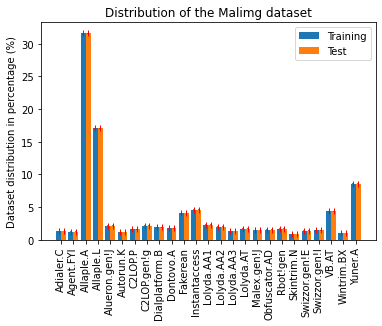

In [58]:
perc_train = np.mean(train_distr, axis = 0)
perc_test =  np.mean(test_distr, axis = 0)

plt.bar(x - 0.2, perc_train, 0.4, label = 'Training')
plt.errorbar(x - 0.2, perc_train, yerr = np.std(train_distr, axis = 0), 
             fmt='|', color='red', capsize = 0)

plt.bar(x + 0.2, perc_test,0.4, label = 'Test')
plt.errorbar(x + 0.2, perc_test, yerr = np.std(train_distr, axis = 0), 
             fmt='|', color='red', capsize=0.0)


plt.title('Distribution of the Malimg dataset')
plt.ylabel('Dataset distribution in percentage (%)')
plt.xticks(x, list(classes), rotation='vertical')
plt.legend()

if cenv == 0:
    plt.savefig("multi_data_dist.png", bbox_inches = 'tight', dpi = 150)
if cenv == 1:
    plt.savefig(f"{new_dir}/multi_data_dist.png", bbox_inches = 'tight', dpi = 150)

In [59]:
t = PrettyTable(['Metric', 'Performance', 'St.Deviation'])
t.add_row(['M-Class', "", ""])
t.add_row(['Acc    ', round(np.mean(multi_acc_per_fold),4), round(np.std(multi_acc_per_fold),4)])
t.add_row(['Loss   ', round(np.mean(loss_per_fold),4), round(np.std(loss_per_fold),4)])
t.add_row(['Macro F1     ', round(np.mean(multi_f1_per_fold),4), round(np.std(multi_f1_per_fold),4)])
t.border = True
t.header = True
t.set_style(MSWORD_FRIENDLY)
t.align = "l"
t.title = "Performance of CNN on Malimg"
print(t)

+--------------------------------------------+
|        Performance of CNN on Malimg        |
| Metric        | Performance | St.Deviation |
| M-Class       |             |              |
| Acc           | 0.9746      | 0.0047       |
| Loss          | 0.0883      | 0.0212       |
| Macro F1      | 0.9186      | 0.011        |


In [60]:
# Saving PrettyTable
table = t.get_string()

if cenv == 0:
    with open('multi_performance_table.txt', 'w') as f:
        f.write(table)
if cenv == 1:
    with open(f'{new_dir}/multi_performance_table.txt', 'w') as f:
        f.write(table)

Evaluate the model based on the test set

Save a table with the performance on the test set

**Evaluating overfitting and other model performance measures**

In [61]:
linecolours = ['gray', 'orange', 'blue', 'green','silver', 'cyan', 'red', 'purple', 'lightgreen', 'black', 'brown']

In [62]:
def eval_metric(model, history, metric_name, ymin, ymax):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    for i in range(n_folds-1):  
        metric = history[i].history[metric_name]
        val_metric = history[i].history['val_' + metric_name]
        e = range(1, epoch_t + 1)
        plt.plot(e, metric, marker = 'o', linestyle = 'none', color = linecolours[i])
        plt.plot(e, val_metric, color = linecolours[i])
        
    metric = history[n_folds-1].history[metric_name]
    val_metric = history[n_folds-1].history['val_' + metric_name]
    e = range(1, epoch_t + 1)
    plt.plot(e, metric, marker = 'o', linestyle = 'none', label = 'Training', color = linecolours[n_folds-1])
    plt.plot(e, val_metric, label = 'Validation', color = linecolours[n_folds-1])
    
    plt.ylim(ymin, ymax)
    
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + ' for CNN across folds')
    plt.legend()
    if cenv == 0:
        plt.savefig(f"cnn_model_{metric_name}.png", bbox_inches = 'tight', dpi = 150)
    if cenv == 1:
        plt.savefig(f"{new_dir}/cnn_model_{metric_name}.png", bbox_inches = 'tight', dpi = 150)

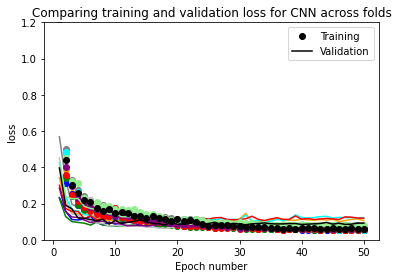

In [63]:
eval_metric(Malware_model, history, 'loss', 0, 1.2)

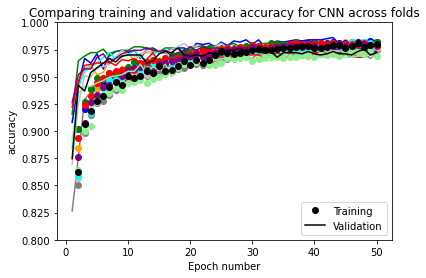

In [64]:
eval_metric(Malware_model, history, 'accuracy', 0.8, 1)

**Confusion Matrix**

In [65]:
c_matrix = metrics.confusion_matrix(y_true, y_pred)
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
   
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if cenv == 0:
        plt.savefig("multi_class_cmatrix.png", bbox_inches = 'tight', dpi = 150)
    if cenv == 1:
        plt.savefig(f"{new_dir}/multi_class_cmatrix.png", bbox_inches = 'tight', dpi = 150)

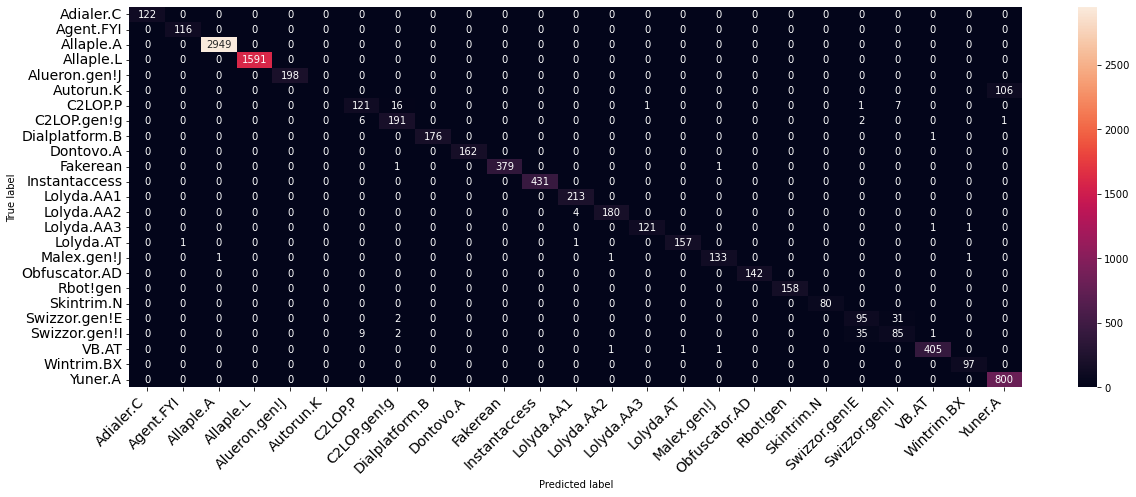

In [66]:
class_names= batches.class_indices.keys()
confusion_matrix(c_matrix, class_names, figsize = (20,7), fontsize=14)